# stock4_ichmoku
## 概要
* yahoo financeより株価データを取得する
* 一目均衡表を作成する
* グラフ画像をファイル保存する
## 参考
### キノコード：株価のデータ分析(4)
* https://youtu.be/xihK3A40pZ8
* https://kino-code.com/python_finance-02/
### install packages
* pip install pandas_datareader
* pip install mplfinance
* TA-Libのインストール:https://optrip.xyz/?p=2242

### 一目均衡表とは
* 一目均衡表とは、日本発祥のテクニカル指標の一つ
* 主に基準線、転換線、先行スパン、遅行線の4つの要素で構成される
  * 基準線は、過去26日間の最高値と最安値の平均を結んだ線
  * 転換線は、過去9日間の最高値と最安値の平均を結んだ線
  * 先行スパンは、2つの線で構成される
    * 先行スパン1は、基準線と転換線の平均を結んだ線を26日分未来にずらした線
    * 先行スパン2は、過去52日間の最高値と最安値の平均を結んだ線を26日分未来にずらした線
      * 2本の先行スパンに挟まれた領域を雲と呼ぶ
      * ローソク足が雲の上にある時は上昇トレンド、雲の下にある時は下降トレンドであると判断される
      * 先行スパンが交わるところは雲のねじれとも呼ばれ、トレンドの転換が予測される
  * 遅行線は、当日の終値を26日分過去にずらした線
    * 遅行線がローソク足を上回った場合は買いのタイミング、逆に下回った場合を売りのタイミングであったと判断される

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mplfinance as mpf
from pandas_datareader import data as pdr
import yfinance as yf

In [2]:
# 日経平均データ（~N225）の取得
ticker = '^N225'
start = '2019-11-01'
end = '2020-11-01'

yf.pdr_override()
df = pdr.get_data_yahoo(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
# 基準線データの作成
high = df['High']
low = df['Low']

max26 = high.rolling(window=26).max()
min26 = low.rolling(window=26).min()

df['basic_line'] = ( max26 + min26 ) / 2

In [4]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,basic_line
Date,,,,,,,
2020-10-28,23372.609375,23451.029297,23334.230469,23418.509766,23418.509766,67100000,23338.495117
2020-10-29,23170.759766,23374.099609,23170.759766,23331.939453,23331.939453,57500000,23338.495117
2020-10-30,23320.710938,23320.710938,22948.470703,22977.130859,22977.130859,76700000,23337.025391


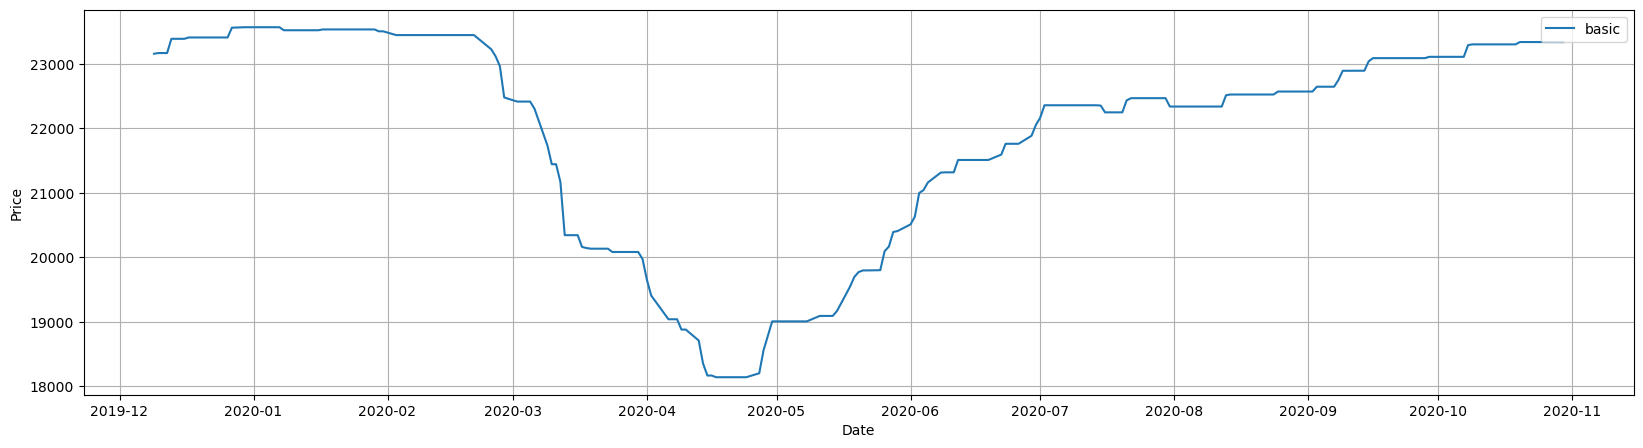

In [5]:
plt.figure(figsize=(20,5))
plt.plot(df['basic_line'], label='basic')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [6]:
# 転換線データの作成
high9 = high.rolling(window=9).max()
low9 =  low.rolling(window=9).min()

df['turn_line'] = ( high9 + low9 ) / 2

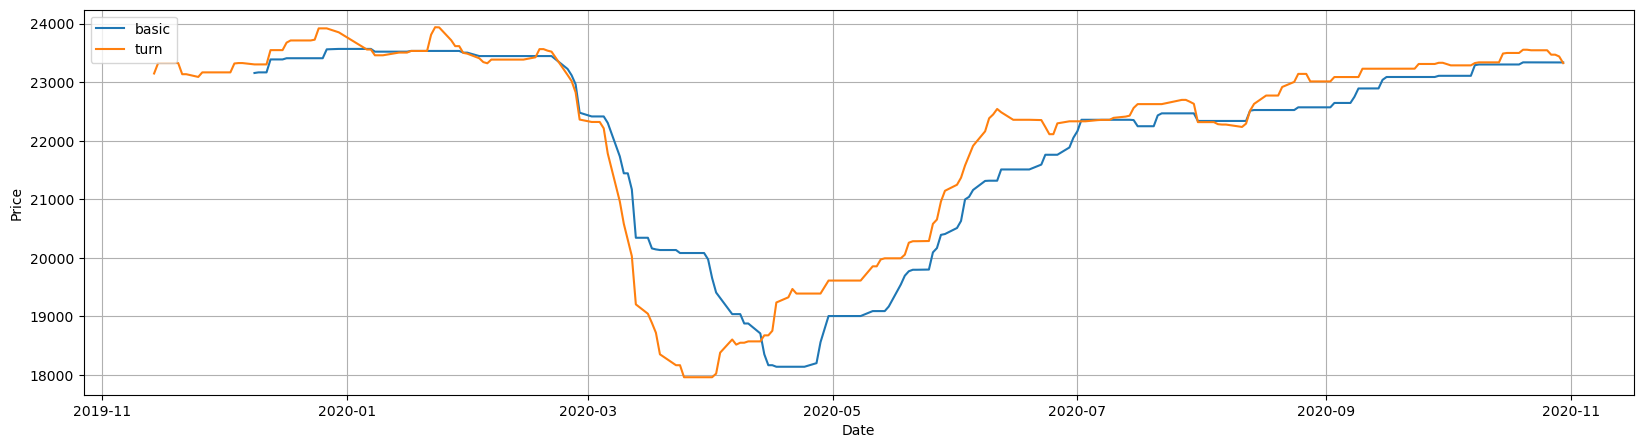

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df['basic_line'], label='basic')
plt.plot(df['turn_line'], label='turn')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [8]:
# 雲データ（先行スパン1、先行スパン2）の作成
# 26日分未来は当日を含めてであるため25日分シフト
df['span1'] = ((df['basic_line'] + df['turn_line']) / 2).shift(25)

high52 = high.rolling(window=52).max()
low52 =  low.rolling(window=52).min()

df['span2'] = (( high52 + low52 ) / 2).shift(25)

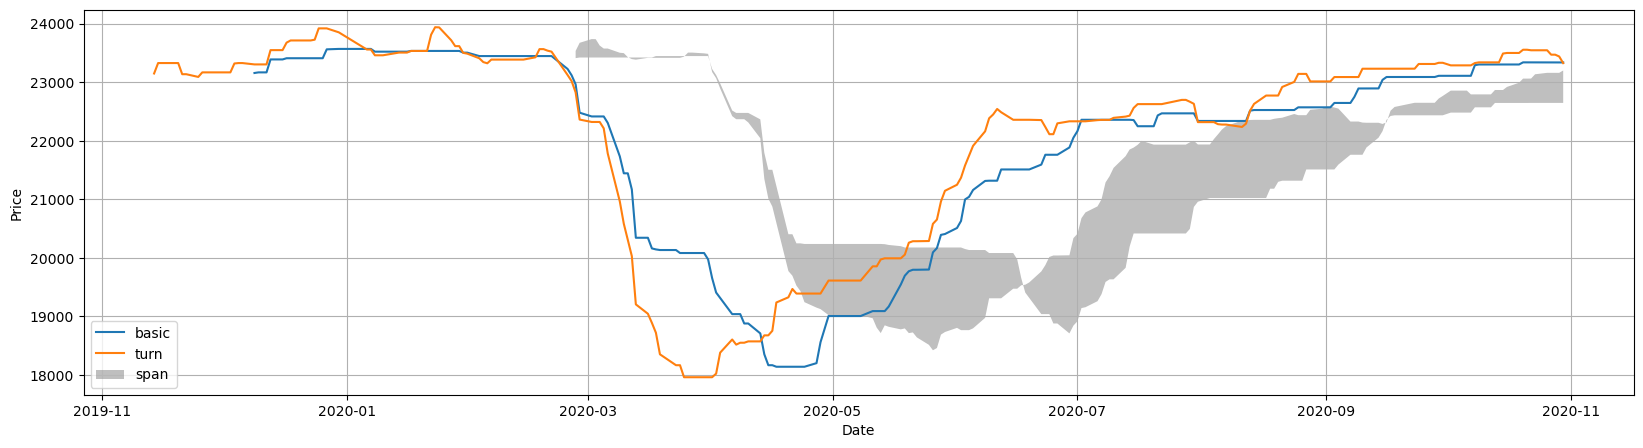

In [9]:
plt.figure(figsize=(20,5))
plt.plot(df['basic_line'], label='basic')
plt.plot(df['turn_line'], label='turn')
date = df.index
plt.fill_between(date, df['span1'], df['span2'], facecolor="gray", alpha=0.5, label="span")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [10]:
# 遅行線データの作成
df['slow_line'] = df['Adj Close'].shift(-25)

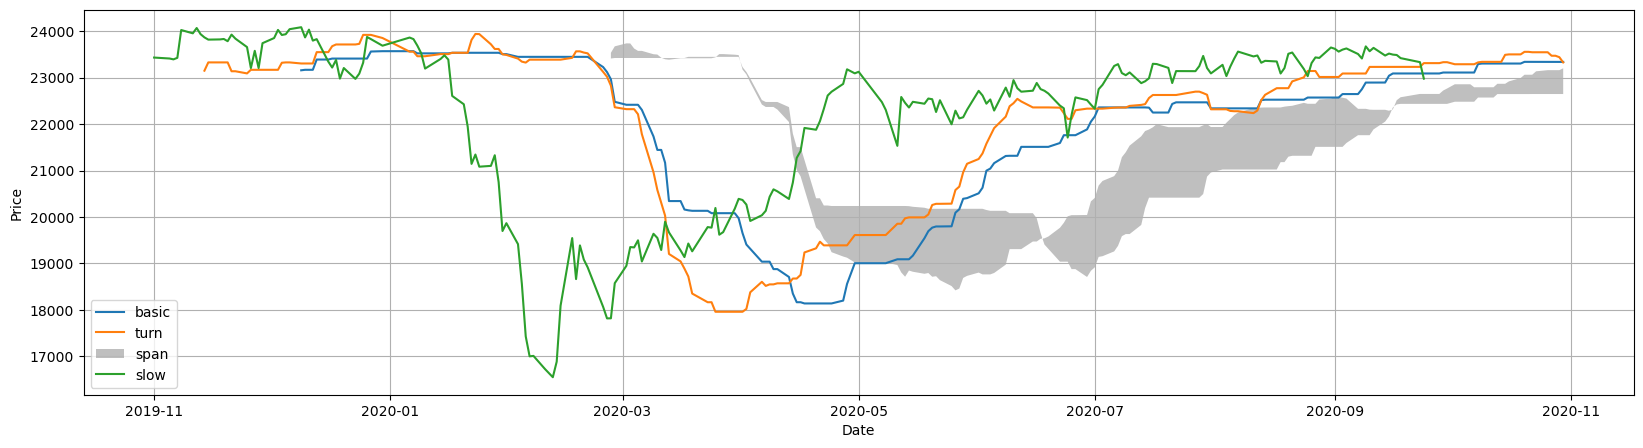

In [11]:
plt.figure(figsize=(20,5))
plt.plot(df['basic_line'], label='basic')
plt.plot(df['turn_line'], label='turn')
plt.fill_between(date, df['span1'], df['span2'], facecolor="gray", alpha=0.5, label="span")
plt.plot(df['slow_line'], label='slow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

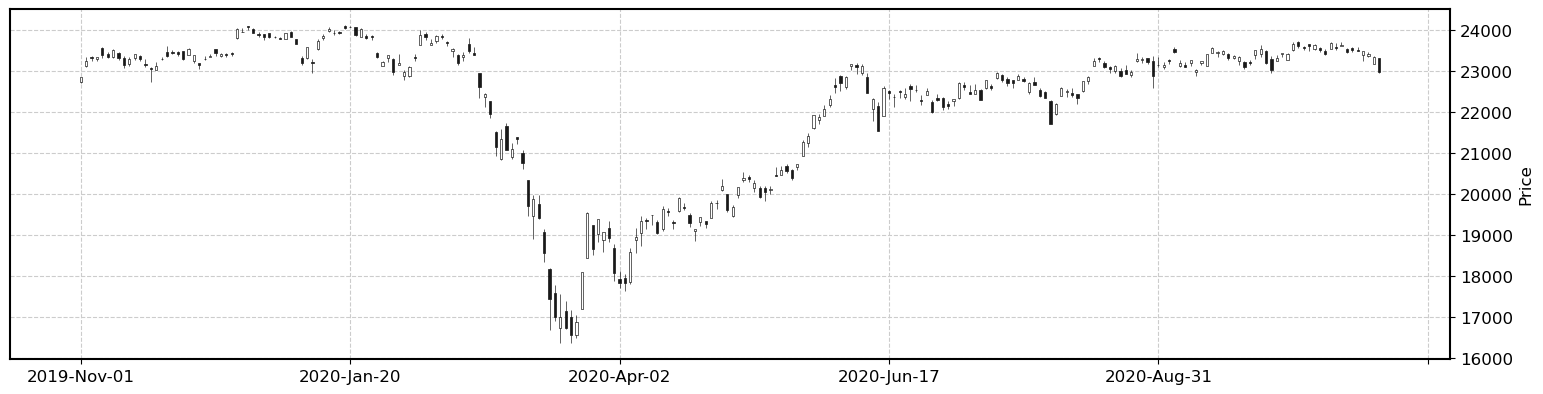

In [12]:
# ローソク足グラフの作成
mpf.plot(df,type='candle',figsize=(20,5),style='classic', xrotation=0)

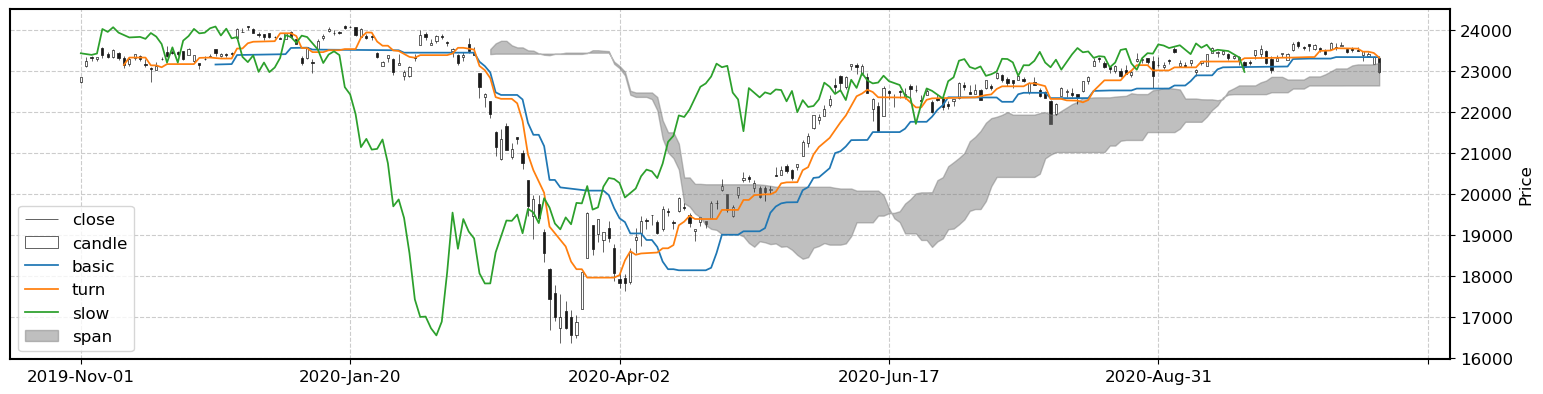

In [13]:
# 一目近況表の作成
lines = [mpf.make_addplot(df['basic_line']), #基準線
        mpf.make_addplot(df['turn_line']),   #転換線
        mpf.make_addplot(df['slow_line']),   #遅行線
       ] 

fig, ax = mpf.plot(df, type='candle', figsize=(20,5), style='classic', xrotation=0, addplot=lines, returnfig=True,
                  fill_between=dict(y1=df['span1'].values, y2=df['span2'].values, alpha=0.5, color='gray') ) 
labels = ["close", "candle", "basic", "turn", "slow", "span"]
ax[0].legend(labels)
plt.show()

In [14]:
# グラフをファイル保存
lines = [mpf.make_addplot(df['basic_line']), #基準線
        mpf.make_addplot(df['turn_line']),   #転換線
        mpf.make_addplot(df['slow_line']),   #遅行線
       ] 

fig, ax = mpf.plot(df, type='candle', figsize=(20,5), style='classic', xrotation=0, addplot=lines, returnfig=True,
                  fill_between=dict(y1=df['span1'].values, y2=df['span2'].values, alpha=0.5,color='gray'), savefig='ichimoku.png' ) 